In [2]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import matplotlib.lines
import numpy as np
import socialforce

[Sven Kreiss](https://www.svenkreiss.com), April 17 2020

# Loss Landscape for 1D Predictions

Purpose: study optimization stability.

## One-Step Prediction

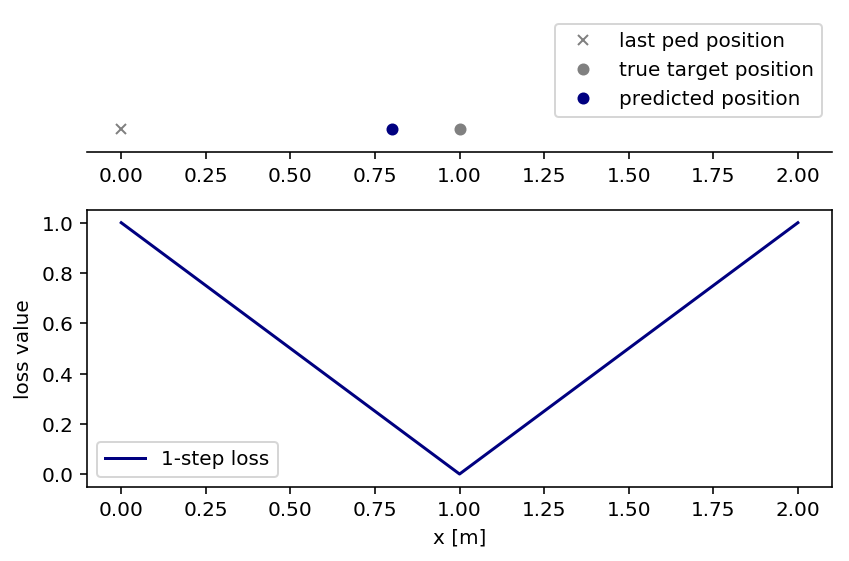

In [7]:
target = 1.0
with socialforce.show.canvas(
        'images/onedimensional_1pred.png',
        nrows=2, gridspec_kw={'height_ratios': [1, 2]}, figsize=(6, 4),
) as (ax1, ax2):
    ax1.spines['left'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    ax1.set_ylim(-0.1, 0.5)
    ax1.set_xlim(-0.1, 2.1)
    ax1.plot([0.0], [0.0], 'x', label='last ped position', markersize=5.0, color='grey')
    ax1.plot([1.0], [0.0], 'o', label='true target position', markersize=5.0, color='grey')
    ax1.plot([0.8], [0.0], 'o', label='predicted position', markersize=5.0, color='navy')
    ax1.legend()

    x = np.linspace(0.0, 2.0, 101)
    loss_landscape = np.abs(x - target)
    ax2.plot(x, loss_landscape, '-', label='1-step loss', color='navy')
    ax2.legend()
    ax2.set_xlabel('x [m]')
    ax2.set_ylabel('loss value')

## Two-Step Prediction

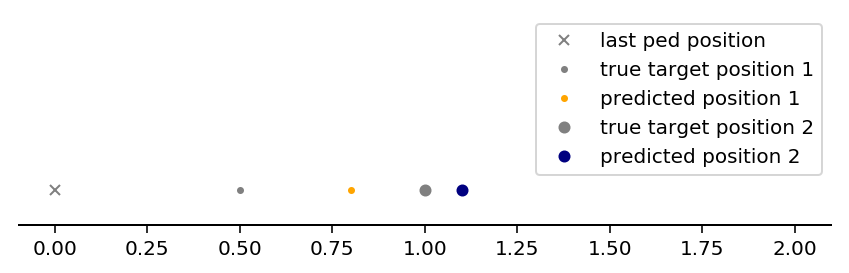

In [8]:
with socialforce.show.canvas('images/onedimensional_2pred_scenario.png', figsize=(6, 2.0)) as ax:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    ax.set_ylim(-0.1, 0.5)
    ax.set_xlim(-0.1, 2.1)
    xmin, xmax = ax.get_xaxis().get_view_interval()
    ymin, _ = ax.get_yaxis().get_view_interval()
    ax.add_artist(matplotlib.lines.Line2D(
        (xmin, xmax), (ymin, ymin), color='black', linewidth=2))

    ax.plot([0.0], [0.0], 'x', label='last ped position', markersize=5.0, color='grey')
    ax.plot([0.5], [0.0], 'o', label='true target position 1', markersize=2.5, color='grey')
    ax.plot([0.8], [0.0], 'o', label='predicted position 1', markersize=2.5, color='orange')
    ax.plot([1.0], [0.0], 'o', label='true target position 2', markersize=5.0, color='grey')
    ax.plot([1.1], [0.0], 'o', label='predicted position 2', markersize=5.0, color='navy')
    ax.legend()

In [30]:
target = 1.0
x1 = np.linspace(0.0, 2.0, 101)
x2 = np.linspace(-1.0, 1.0, 101)
xx1, xx2 = np.meshgrid(x1, x2, sparse=True)

def contourplot(ax, loss):
    conditional_argx2 = np.argmin(loss, axis=0)
    ax.plot(x1, x2[conditional_argx2], ls='dotted', color='black', label='conditional minimum')
    ax.clabel(
        ax.contour(x1, x2, loss, levels=np.linspace(0.1, 5.0, 50), vmax=1.0), 
        inline=1, fontsize=10)
    ax.plot([0.5], [0.5], 'o', label='true target position', markersize=5.0, color='black')
    ax.set_xlabel('$x_1$ [m]')
    ax.set_ylabel('$x_2$ [m]')
    ax.legend()

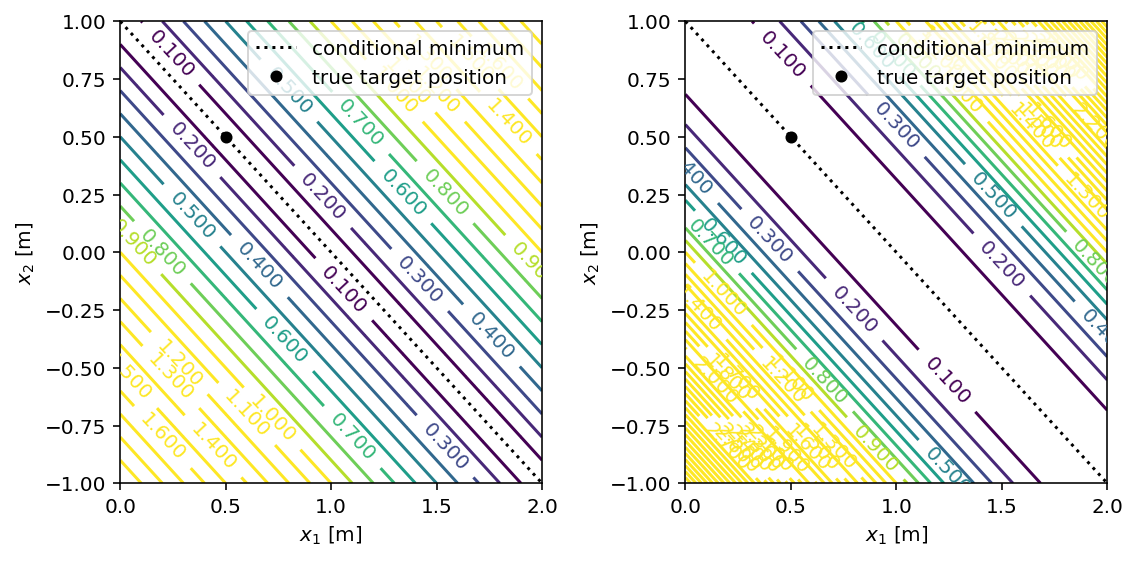

In [31]:
loss_fde_abs = np.abs(target - (xx1 + xx2))
loss_fde_sq = np.square(target - (xx1 + xx2))
with socialforce.show.canvas('images/onedimensional_2pred_fde.png', ncols=2, figsize=(8, 4)) as (ax1, ax2):
    contourplot(ax1, loss_fde_abs)
    contourplot(ax2, loss_fde_sq)

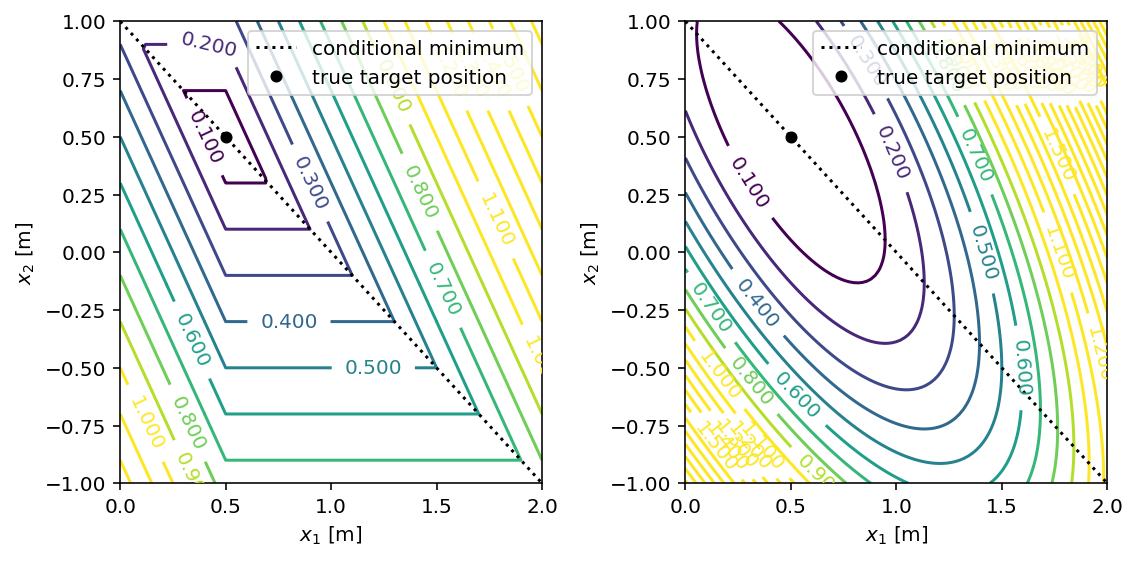

In [32]:
loss_ade_abs = 0.5 * np.abs(target/2.0 - xx1) + 0.5 * np.abs(target - (xx1 + xx2))
loss_ade_sq = 0.5 * np.square(target/2.0 - xx1) + 0.5 * np.square(target - (xx1 + xx2))
with socialforce.show.canvas('images/onedimensional_2pred_ade.png', ncols=2, figsize=(8, 4)) as (ax1, ax2):
    contourplot(ax1, loss_ade_abs)
    contourplot(ax2, loss_ade_sq)

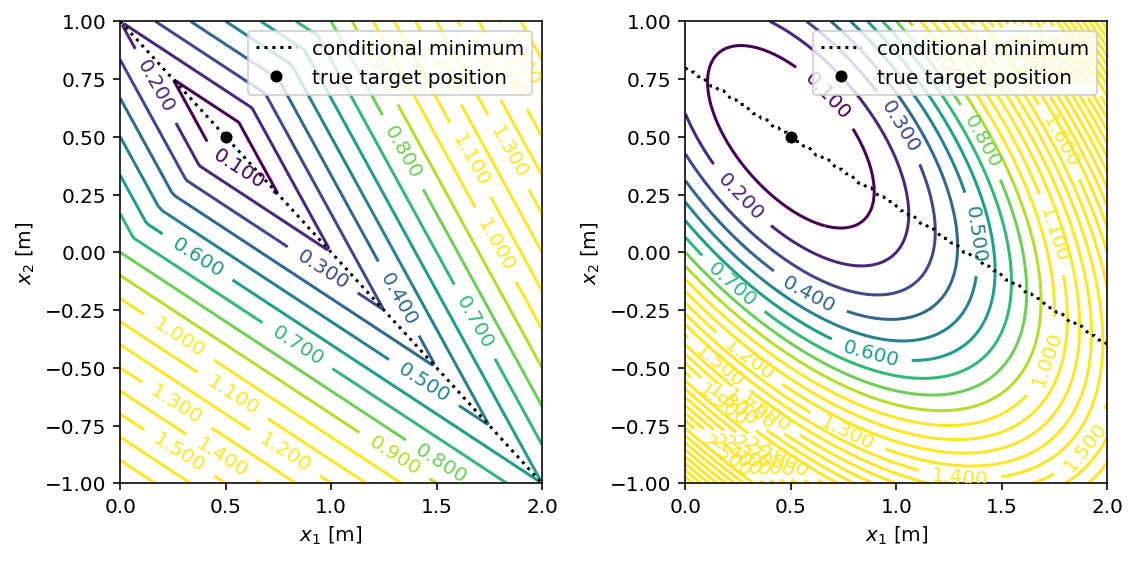

In [33]:
loss_fdees_abs = 0.2 * np.abs(xx2 - xx1) + 0.8 * np.abs(target - (xx1 + xx2))
loss_fdees_sq = 0.2 * np.square(xx2 - xx1) + 0.8 * np.square(target - (xx1 + xx2))
with socialforce.show.canvas('images/onedimensional_2pred_fdees.png', ncols=2, figsize=(8, 4)) as (ax1, ax2):
    contourplot(ax1, loss_fdees_abs)
    contourplot(ax2, loss_fdees_sq)

# Conclusion

FDE is degenerate and therefore not great for optimization.

ADE is non-degenerate. Loss landscape is distorted.

FDE-CV (FDE with constant velocity) is a non-degenerate version of FDE. However, the constraint to constant velocity might not be too realistic and could be annealed.


## Optimization Scenario

Some Social Force simulations are unstable with a 0.4s (2.5FPS) timestep (see `opposing` experiments). It might be necessary to oversample by a factor of 4x, i.e., do three steps without a supervised annotation before the next supervision. The oversampled steps produce a loss landscale as in the FDE scenario. As ADE is not an option, a constant velocity regularization is necessary.